In [1]:
import warnings

warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")  # silence LAL warning

In [361]:
from numpy.random import random
from pyseobnr.generate_waveform import GenerateWaveform, generate_modes_opt
from gwtools import mismatch
import numpy as np
import matplotlib.pyplot as plt
import rompy as rp
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.regularizers import l2

## Non-accelerated Surrogate Model Class

In [132]:
class GWSurrogateModel:
    def __init__(self, tolerance=1e-12):
        self.tolerance = tolerance

        # Parameter ranges
        self.q_range = [1.0, 8.0]  # Mass ratio
        self.chi_range = [-0.99, 0.99]  # Dimensionless spin

        # Time domain information
        self.M_total = 60.0  # Total mass in solar masses
        self.M_sol = 4.92549095e-6 # M unit of time, in geometric units
        self.f_min = 8.0  # Minimum frequency at 60 M_sun
        self.time_range = [-20000.0, 100.0]  # Time range in M units
        self.dt = 0.5  # Time step in M units
        
        # Set up time grid
        self.times = np.arange(self.time_range[0], self.time_range[1] + self.dt, self.dt)
        self.n_steps = len(self.times)

        # RomPy integration rule
        self.integration = rp.Integration(self.time_range, num=self.n_steps, rule='trapezoidal')

        # Surrogate models for both amplitude and phase
        self.amplitude_surrogate = rp.Surrogate(self.integration)
        self.phase_surrogate = rp.Surrogate(self.integration)

        self.waveforms = None

    
    def _generate_waveform(self, q, chi_1, chi_2):
        '''
        Generates a GW waveform in the dominant mode (i.e. l = m = 2). Assumes that the two black holes are spin-aligned.
        '''
        # Conversion needed for generate_modes_opt
        # First converts GW frequency to orbital frequency and then converts physical units to geometric units
        omega_start = np.pi * self.f_min * self.M_total * self.M_sol

        t, modes = generate_modes_opt(
            q=q,
            chi1=chi_1,
            chi2=chi_2,
            omega_start=omega_start,
        )

        # Extract h22 mode (dominant)
        h22 = modes['2,2']

        # Extract amplitude and phase
        amp = np.abs(h22)
        phase = np.unwrap(np.angle(h22))

        # Time shift: peak of amplitude at t=0
        peak_idx = np.argmax(amp)
        t_shifted = t - t[peak_idx]

        # Filter data to specified time range
        t_min, t_max = self.time_range
        mask = (t_shifted >= t_min) & (t_shifted <= t_max)

        t_filtered = t_shifted[mask]
        h_filtered = h22[mask]
        amplitude_filtered = amp[mask]
        phase_filtered = phase[mask]

        # Interpolate to uniform grid
        amplitude_interp = np.interp(self.times, t_filtered, amplitude_filtered)
        phase_interp = np.interp(self.times, t_filtered, phase_filtered)
        h_interp = np.interp(self.times, t_filtered, h_filtered)
        
        # Phase shift: phase is zero at start time
        phase_shift = phase_interp[0]
        phase_interp -= phase_shift
        
        return {
            "time": self.times,
            "h": h_interp,
            "amp": amplitude_interp,
            "phase": phase_interp,
        }


    def generate_waveforms(self, N=1000, random_state=None):
        if random_state:
            np.random.seed(random_state)

        q_range = self.q_range
        chi_range = self.chi_range
        
        waveforms = []

        amp_data = np.zeros((N, self.n_steps))
        phase_data = np.zeros((N, self.n_steps))
        
        # Generate random parameters
        q_values = np.random.uniform(q_range[0], q_range[1], N)
        chi1_values = np.random.uniform(chi_range[0], chi_range[1], N)
        chi2_values = np.random.uniform(chi_range[0], chi_range[1], N)
        
        for i in range(N):
            waveform = self._generate_waveform(q_values[i], chi1_values[i], chi2_values[i])
            amp_data[i] = waveform["amp"]
            phase_data[i] = waveform["phase"]
            waveforms.append(waveform)

        # Save waveforms in instance in case we need them later
        if not self.waveforms:
            self.waveforms = waveforms
            self.q_values = q_values
            self.chi1_values = chi1_values
            self.chi2_values = chi2_values

        return {
            "waves": waveforms,
            "amp": amp_data,
            "phase": phase_data,
            "q": q_values,
            "chi1": chi1_values,
            "chi2": chi2_values,
        }

    
    def train(self, waves):
        '''
        Builds the reduced order model (ROM) for both amplitude and phase.
        Expects as input a dictionary like the one produced by the generate_waveforms method.
        '''
        amp_data = waves["amp"]
        phase_data = waves["phase"]
        q_values = waves["q"]
        chi1_values = waves["chi1"]
        chi2_values = waves["chi2"]
        
        # MakeROM performs both ROM and EIM steps in one
        print("Building surrogate model for amplitude...")
        self.amplitude_surrogate.MakeROM(amp_data, 0, self.tolerance, verbose=True)
        self.amplitude_surrogate.ei.data = self.amplitude_surrogate.ei.data.T # dimension mismatch if this isn't transposed

        print("Building surrogate model for phase...")
        self.phase_surrogate.MakeROM(phase_data, 0, self.tolerance, verbose=True)
        self.phase_surrogate.ei.data = self.phase_surrogate.ei.data.T # dimension mismatch if this isn't transposed

        param_list = np.array([q_values, chi1_values, chi2_values])
        
        print("Building fits for amplitude coefficients...")
        self.amplitude_surrogate.MakeFits(param_list, fit='polyfit3d', deg=5)
        
        print("Building fits for phase coefficients...")
        self.phase_surrogate.MakeFits(param_list, fit='polyfit3d', deg=5)
        
        print("Finished ROM + EIM.")

    
    def evaluate(self, q, chi_1, chi_2):
        """
        Evaluate the surrogate model at a new point, given parameters.
        """
        # Multivariate evaluation is weird in RomPy... might be because it's in development purgatory
        # I essentially override its issues by making the params array have shape (3, # of EIM bases)
        num_amp_bases = self.amplitude_surrogate.ei.B.shape[0]
        num_phase_bases = self.phase_surrogate.ei.B.shape[0]
        
        params = np.array([float(q), float(chi_1), float(chi_2)]).reshape(3, 1)
        params_amp_matrix = np.tile(params, num_amp_bases)
        params_phase_matrix = np.tile(params, num_phase_bases)
        
        amplitude = self.amplitude_surrogate.Eval(params_amp_matrix)
        phase = self.phase_surrogate.Eval(params_phase_matrix)
        
        return amplitude, phase
    
        
    def calculate_mismatch(self, h1, h2):
        """Calculate the mismatch between two waveforms"""
        return mismatch.mismatch(h1, h2)[0]


    def _get_rb_projection(self, wave):
        '''
        Project a wave onto the reduced basis.
        '''
        amp_projection = self.amplitude_surrogate.rb.project(wave['amp'])
        phase_projection = self.phase_surrogate.rb.project(wave['phase'])

        return amp_projection * np.exp(-1j * phase_projection)


    def _rb_mismatch(self, wave):
        '''
        Compute the mismatch between a wave and its reduced basis projection.
        '''
        h = wave["amp"] * np.exp(-1j * wave["phase"])
        h_proj = self._get_rb_projection(wave)
        
        return self.integration.mismatch(h, h_proj)


    def rb_mismatches(self, waveforms=None):
        """
        Compute the mismatch between the given waveforms and their reduced basis projections.
        """
        if not waveforms:
            waveforms = self.waveforms
            
        mismatches = []
        for i in range(len(waveforms)):
            wave = waveforms[i]
            mismatch = self._rb_mismatch(wave)
            mismatches.append(mismatch)
        
        print(f"Max mismatch: {np.max(mismatches)}")
        print(f"Min mismatch: {np.min(mismatches)}")
        print(f"Median mismatch: {np.median(mismatches)}")

        return mismatches


    def test(self, waves):
        '''
        Compute the mismatch between the given waveforms and their interpolated approximations.
        '''
        amp_data = waves["amp"]
        phase_data = waves["phase"]
        q_values = waves["q"]
        chi1_values = waves["chi1"]
        chi2_values = waves["chi2"]
        
        mismatches = []
        for i in range(len(amp_data)):
            amp = amp_data[i]
            phase = phase_data[i]
            q = q_values[i]
            chi1 = chi1_values[i]
            chi2 = chi2_values[i]

            # Prediction
            amp_pred, phase_pred = gws.evaluate(q, chi1, chi2)
            pred = amp_pred * np.exp(-1j * phase_pred)

            # Actual
            actual = amp * np.exp(-1j * phase)
                    
            mis = mismatch.mismatch(actual, pred)[0]
            mismatches.append(mis)
        
        print(f"Max mismatch: {np.max(mismatches)}")
        print(f"Min mismatch: {np.min(mismatches)}")
        print(f"Median mismatch: {np.median(mismatches)}")

        return mismatches

### Generate Some Waves

In [504]:
gws = GWSurrogateModel()

In [506]:
sample1 = gws._generate_waveform(2, -0.1, 0.3)
sample2 = gws._generate_waveform(5, 0.3, 0.8)

In [508]:
hsample1 = sample1["amp"] * np.exp(1j * sample1["phase"])
hsample2 = sample2["amp"] * np.exp(1j * sample2["phase"])

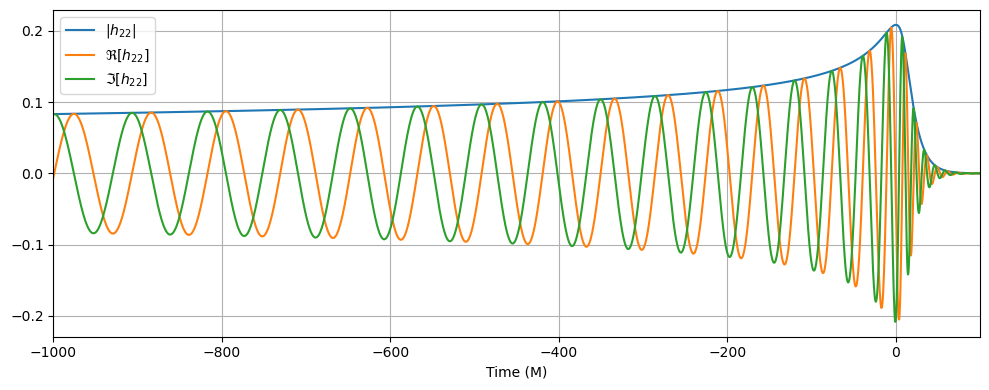

In [510]:
plt.figure(figsize=(10, 4))
plt.plot(sample2["time"], np.abs(hsample2), label='$|h_{22}|$')
plt.plot(sample2["time"], hsample2.real, label=r"$\Re[h_{22}]$")
plt.plot(sample2["time"], hsample2.imag, label=r"$\Im[h_{22}]$")
plt.legend()
plt.grid()
plt.xlim(-1000, 100)
#plt.ylim(0.1,0.5)
#plt.xlim(-20010,-19990)
#plt.ylim(-3,3)
plt.xlabel("Time (M)")
plt.tight_layout()
plt.show()

### Train the Surrogates and Compute Mismatch

In [22]:
# Generate test set
generated_wave_dict = gws.generate_waveforms(N=10000, random_state=42)

In [514]:
# Train on test set (ROM + EIM)
gws.train(generated_wave_dict)

Building surrogate model for amplitude...
('\nStep', '\t', 'Error')
(1, '\t', 184.7385786612738)
(2, '\t', 1.0727769389803825)
(3, '\t', 0.2736106611488438)
(4, '\t', 0.049840702225367295)
(5, '\t', 0.010080702059340751)
(6, '\t', 0.00502506918158474)
(7, '\t', 0.0011192945778475405)
(8, '\t', 0.0005735820749350751)
(9, '\t', 0.00018563834206020147)
(10, '\t', 8.782426034770197e-05)
(11, '\t', 4.1550999824835344e-05)
(12, '\t', 5.098760340160879e-06)
(13, '\t', 1.717172381177079e-06)
(14, '\t', 7.745051817664717e-07)
(15, '\t', 4.88296336698113e-07)
(16, '\t', 2.0947747714217257e-07)
(17, '\t', 9.294861769149065e-08)
(18, '\t', 3.6487790566752665e-08)
(19, '\t', 2.0998449201670155e-08)
(20, '\t', 1.835334018096546e-08)
(21, '\t', 1.3103459650665172e-08)
(22, '\t', 3.811614135429409e-09)
(23, '\t', 3.233623147025355e-09)
(24, '\t', 1.9841763787553646e-09)
(25, '\t', 1.8647767774382373e-09)
(26, '\t', 1.4596537312172586e-09)
(27, '\t', 1.4007071058586007e-09)
(28, '\t', 1.293798845836136

In [515]:
# Generate test data
test_dict = gws.generate_waveforms(N=1000, random_state=0)

In [640]:
amp_pred, phase_pred = gws.evaluate(2, -0.1, 0.3)
pred = amp_pred * np.exp(1j * phase_pred)

In [636]:
gws.calculate_mismatch(hsample1, pred)

0.0001502430398060417

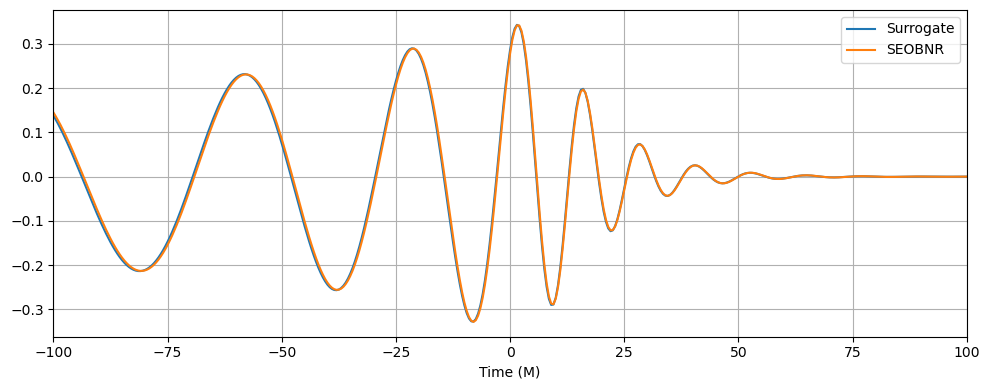

In [638]:
plt.figure(figsize=(10, 4))
plt.plot(sample2["time"], pred.real, label='Surrogate')
plt.plot(sample2["time"], hsample1.real, label='SEOBNR')
#plt.plot(sample2["time"], hsample2.imag, label=r"$\Im[h_{22}]$")
plt.legend()
plt.grid()
plt.xlim(-100, 100)
#plt.ylim(0.1,0.5)
#plt.xlim(-20010,-19990)
#plt.ylim(-3,3)
plt.xlabel("Time (M)")
plt.tight_layout()
plt.show()

### ANN-Accelerated Surrogate Model

In [363]:
class ANNSurrogateModel(GWSurrogateModel):
    def __init__(self, tolerance=1e-12):
        super().__init__(tolerance)

        # Neural network models for amplitude and phase
        self.amplitude_model = None
        self.phase_model = None
        
        # Data preprocessing 
        self.X_scaler = StandardScaler()  # For input parameters
        self.phase_Y_scaler = MinMaxScaler()  # For phase coefficients
        # No scaling for amplitude coefficients as per Section IV.A

    
    def build_training_data(self, waves):
        """
        Builds and scales training data for the neural networks. Returns both X (input params) and Y (EIM coefficients).
        """
        self.train(waves)
        
        amp_data = waves["amp"]
        phase_data = waves["phase"]
        q_values = waves["q"]
        chi1_values = waves["chi1"]
        chi2_values = waves["chi2"]

        num_amp_bases = self.amplitude_surrogate.ei.B.shape[0]
        num_phase_bases = self.phase_surrogate.ei.B.shape[0]
        
        # Create and scale inputs (X)
        X = np.column_stack([
            np.log(q_values),
            chi1_values,
            chi2_values
        ])
        X_scaled = self.X_scaler.fit_transform(X)

        # Get EIM coefficients from traditional surrogate
        amplitude_coeffs = []
        phase_coeffs = []
        
        for q, chi1, chi2 in zip(q_values, chi1_values, chi2_values):
            params = np.array([float(q), float(chi1), float(chi2)]).reshape(3, 1)
            params_amp_matrix = np.tile(params, num_amp_bases)
            params_phase_matrix = np.tile(params, num_phase_bases)
            
            # Get coefficients
            amp_coeff = self.amplitude_surrogate.fits.eval(params_amp_matrix)
            phase_coeff = self.phase_surrogate.fits.eval(params_phase_matrix)
            
            amplitude_coeffs.append(amp_coeff)
            phase_coeffs.append(phase_coeff)
            
        amplitude_coeffs = np.array(amplitude_coeffs)
        phase_coeffs = np.array(phase_coeffs)
        
        # Scale phase coefficients but not amplitude coefficients (Section IV.A)
        phase_coeffs_scaled = self.phase_Y_scaler.fit_transform(phase_coeffs)

        self.amplitude_coeffs = amplitude_coeffs
        self.phase_coeffs = phase_coeffs_scaled
        self.X = X_scaled
        
        return X_scaled, amplitude_coeffs, phase_coeffs_scaled
    
    def build_neural_networks(self):
        """
        Builds neural networks for amplitude and phase. Run after running build_training_data.
        """
        # Get dimensions
        n_amplitude_coeffs = self.amplitude_surrogate.ei.B.shape[0]
        n_phase_coeffs = self.phase_surrogate.ei.B.shape[0]
        
        # Amplitude network
        inputs = Input(shape=(3,))
        x = Dense(320, activation='relu', kernel_regularizer=l2(1e-4))(inputs)
        x = Dense(320, activation='relu')(x)
        x = Dense(320, activation='relu')(x)
        x = Dense(320, activation='relu')(x)
        outputs = Dense(n_amplitude_coeffs, activation='linear')(x)
        self.amplitude_model = Model(inputs=inputs, outputs=outputs)
        
        # Phase network
        inputs = Input(shape=(3,))
        x = Dense(320, activation='softplus')(inputs)
        x = Dense(320, activation='softplus')(x)
        x = Dense(320, activation='softplus')(x)
        x = Dense(320, activation='softplus')(x)
        outputs = Dense(n_phase_coeffs, activation='linear')(x)
        self.phase_model = Model(inputs=inputs, outputs=outputs)
        
        # Compile amplitude model with Adam optimizer
        self.amplitude_model.compile(
            optimizer=Adam(learning_rate=1e-3),
            loss='mse'
        )
        
        # Compile phase model with AdaMax optimizer
        self.phase_model.compile(
            optimizer=Adamax(learning_rate=1e-3),
            loss='mse'
        )
        
        print("Neural networks built successfully.")
    
    def train_nn(self, epochs=100, batch_size=100, factor=0.1, patience=200, min_lr=1e-5, verbose=1):
        """
        Train the amplitude and phase neural networks and output their training histories.
        """
        X = self.X
        amplitude_coeffs = self.amplitude_coeffs
        phase_coeffs = self.phase_coeffs
        
        # Learning rate scheduler callback as described in the paper
        lr_schedule = ReduceLROnPlateau(
            monitor='val_loss',
            factor=factor,
            patience=patience,
            min_lr=min_lr,
            verbose=1
        )

        print("Training amplitude model...")
        history_amplitude = self.amplitude_model.fit(
            X, amplitude_coeffs,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.1,
            callbacks=[lr_schedule],
            verbose=verbose
        )
        
        print("Training phase model...")
        history_phase = self.phase_model.fit(
            X, phase_coeffs,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.1,
            callbacks=[lr_schedule],
            verbose=verbose
        )
        
        return history_amplitude, history_phase, lr_schedule

    def plot_training_history(self, amplitude_history, phase_history, learning_rate_schedule=None):
        plt.figure(figsize=(10, 8))
        
        # If learning rate schedule is provided, plot it on top panel
        if learning_rate_schedule is not None:
            plt.subplot(2, 1, 1)
            plt.semilogy(learning_rate_schedule, label='learning rate')
            plt.grid(True, which="both", ls="-", alpha=0.2)
            plt.ylabel('learning rate')
            plt.title('Training History')
            plt.legend()
        
        plt.subplot(2, 1, 2) if learning_rate_schedule is not None else plt.subplot(1, 1, 1)
        
        plt.semilogy(amplitude_history.history['loss'], label='loss (amp)', color='orange')
        if 'val_loss' in amplitude_history.history:
            plt.semilogy(amplitude_history.history['val_loss'], label='val-loss (amp)', color='blue')
        
        plt.semilogy(phase_history.history['loss'], label='loss (phase)', color='red')
        if 'val_loss' in phase_history.history:
            plt.semilogy(phase_history.history['val_loss'], label='val-loss (phase)', color='green')
        
        plt.grid(True, which="both", ls="-", alpha=0.2)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    def evaluate_nn(self, q, chi1, chi2):
        """
        Evaluate the ANN surrogate model at a new point with the given parameters.
        """
        # Transform parameters
        X = np.array([[np.log(q), chi1, chi2]], dtype=np.float32)
        X_scaled = self.X_scaler.transform(X)
        X_tensor = tf.convert_to_tensor(X_scaled, dtype=tf.float32)
        
        # Predict EIM coefficients using neural networks
        amplitude_coeffs = self.amplitude_model(X_tensor, training=False).numpy()[0]
        phase_coeffs_scaled = self.phase_model(X_tensor, training=False).numpy()[0]
        
        # Unscale phase coefficients
        phase_coeffs = self.phase_Y_scaler.inverse_transform(phase_coeffs_scaled.reshape(1, -1))[0]
        
        # Reconstruct waveform using EIM basis
        amplitude = np.dot(amplitude_coeffs, self.amplitude_surrogate.ei.B)
        phase = np.dot(phase_coeffs, self.phase_surrogate.ei.B)
        
        return amplitude, phase
    
    

#### Train and Evaluate the NNs

In [407]:
ann_model = ANNSurrogateModel()

In [82]:
small_train = ann_model.generate_waveforms(N=100, random_state=42)

In [409]:
X, amp_coeffs, phase_coeffs = ann_model.build_training_data(generated_wave_dict)

Building surrogate model for amplitude...
('\nStep', '\t', 'Error')
(1, '\t', 184.7385786612738)
(2, '\t', 1.0727769389803825)
(3, '\t', 0.2736106611488438)
(4, '\t', 0.049840702225367295)
(5, '\t', 0.010080702059340751)
(6, '\t', 0.00502506918158474)
(7, '\t', 0.0011192945778475405)
(8, '\t', 0.0005735820749350751)
(9, '\t', 0.00018563834206020147)
(10, '\t', 8.782426034770197e-05)
(11, '\t', 4.1550999824835344e-05)
(12, '\t', 5.098760340160879e-06)
(13, '\t', 1.717172381177079e-06)
(14, '\t', 7.745051817664717e-07)
(15, '\t', 4.88296336698113e-07)
(16, '\t', 2.0947747714217257e-07)
(17, '\t', 9.294861769149065e-08)
(18, '\t', 3.6487790566752665e-08)
(19, '\t', 2.0998449201670155e-08)
(20, '\t', 1.835334018096546e-08)
(21, '\t', 1.3103459650665172e-08)
(22, '\t', 3.811614135429409e-09)
(23, '\t', 3.233623147025355e-09)
(24, '\t', 1.9841763787553646e-09)
(25, '\t', 1.8647767774382373e-09)
(26, '\t', 1.4596537312172586e-09)
(27, '\t', 1.4007071058586007e-09)
(28, '\t', 1.293798845836136

In [200]:
X = np.array([[np.log(1), 1, 1]])
X_scaled = ann_model.X_scaler.transform(X)
y_pred = ann_model.amplitude_model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [413]:
ann_model.build_neural_networks()

Neural networks built successfully.


In [415]:
history_amplitude, history_phase, lr_schedule = ann_model.train_nn(epochs=1000, batch_size=100, factor=0.2, verbose=False)

Training amplitude model...

Epoch 204: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 404: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 604: ReduceLROnPlateau reducing learning rate to 1e-05.
Training phase model...

Epoch 220: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 420: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 620: ReduceLROnPlateau reducing learning rate to 1e-05.


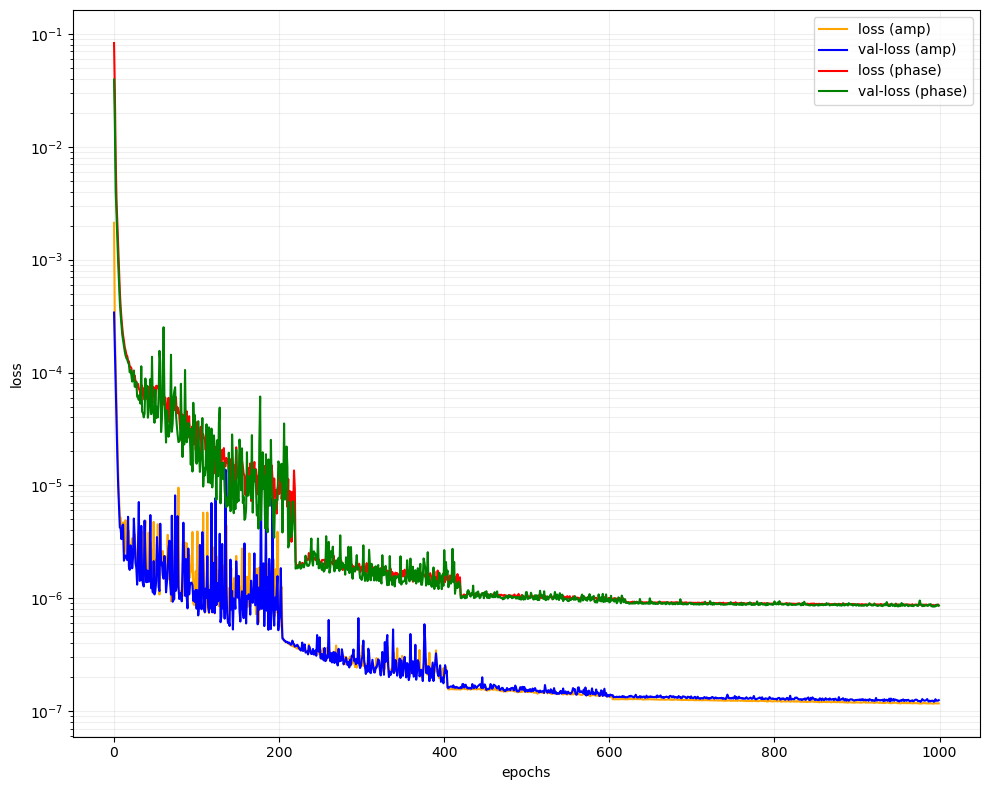

In [417]:
ann_model.plot_training_history(history_amplitude, history_phase)

In [642]:
amp, phase = ann_model.evaluate_nn(5, 0.3, 0.8)

In [201]:
amp1, phase1 = ann_model.evaluate_nn(2, -0.1, 0.3)

In [203]:
annh1 = amp1 * np.exp(1j * phase1)

In [421]:
annh = amp * np.exp(1j * phase)

In [ ]:
def test(waves):
        '''
        Compute the mismatch between the given waveforms and their interpolated approximations.
        '''
        amp_data = waves["amp"]
        phase_data = waves["phase"]
        q_values = waves["q"]
        chi1_values = waves["chi1"]
        chi2_values = waves["chi2"]
        
        mismatches = []
        for i in range(len(amp_data)):
            amp = amp_data[i]
            phase = phase_data[i]
            q = q_values[i]
            chi1 = chi1_values[i]
            chi2 = chi2_values[i]

            # Prediction
            amp_pred, phase_pred = ann_model.evaluate_nn(q, chi1, chi2)
            pred = amp_pred * np.exp(-1j * phase_pred)

            # Actual
            actual = amp * np.exp(-1j * phase)
                    
            mis = mismatch.mismatch(actual, pred)[0]
            mismatches.append(mis)
        
        print(f"Max mismatch: {np.max(mismatches)}")
        print(f"Min mismatch: {np.min(mismatches)}")
        print(f"Median mismatch: {np.median(mismatches)}")

        return mismatches

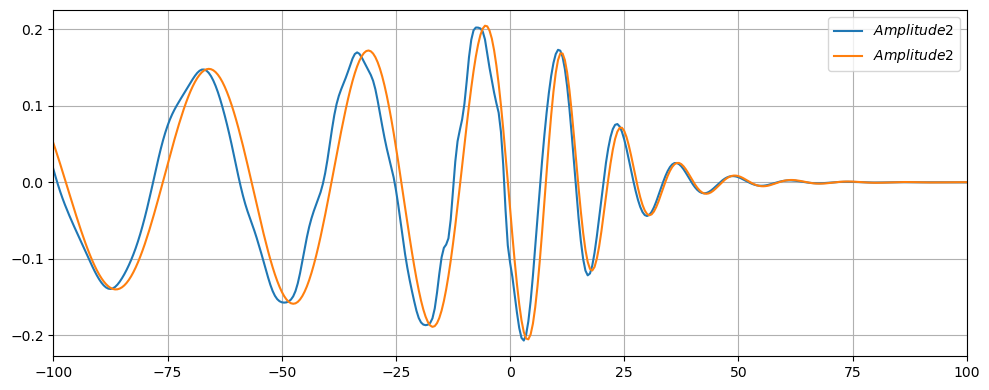

In [437]:
plt.figure(figsize=(10, 4))
#plt.plot(sample1["time"], np.abs(hsample1), label='$Amplitude 1$')
plt.plot(sample2["time"], annh.real, label='$Amplitude 2$')
plt.plot(sample2["time"], hsample2.real, label='$Amplitude 2$')
#plt.plot(sample2["time"], amp1, label='$Amplitude 2$')
#plt.plot(sample2["time"], phase1, label='$Amplitude 2$')
#plt.plot(sample2["time"], phase, label='$Amplitude 2$')
#plt.plot(sample1["time"], np.unwrap(np.angle(hsample2)), label='$Real Part 1$')
#plt.plot(sample1["time"], np.unwrap(np.angle(hsample1)), label='$Real Part 1$')
plt.legend()
plt.grid()
plt.xlim(-100, 100)
#plt.xlim(-100, 100)
#plt.ylim(-800,-500)
#plt.xlim(-20010,-19990)
#plt.ylim(-3,3)
plt.tight_layout()
plt.show()